<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/10xFB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Tue Apr 27 22:11:25 UTC 2021


In [60]:
!rm -rf BMGP_2020
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 221, done.
remote: Total 221 (delta 0), reused 0 (delta 0), pack-reused 221
Receiving objects: 100% (221/221), 186.63 MiB | 27.38 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Checking out files: 100% (64/64), done.


In [3]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 \

     |████████████████████████████████| 59.1MB 86kB/s 
     |████████████████████████████████| 133kB 43.1MB/s 
     |████████████████████████████████| 13.2MB 342kB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 10.3MB 28.3MB/s 
     |████████████████████████████████| 112kB 47.6MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 1.2MB 41.2MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 


In [4]:
# extract everything
!ls /content/BMGP_2020/data/10xFB_5k_pbmc_v3/*/*.tar.gz |xargs -n1 tar -xf

In [4]:
!gunzip /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/*

In [5]:
!cat /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/xaa \
/content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/xab > \
/content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/matrix.mtx

In [6]:
!mv /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix ./

In [65]:
!pip install --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.5

^C
Traceback (most recent call last):
  File "/home/sina/bin/miniconda3/bin/pip", line 6, in <module>
    from pip._internal.cli.main import main
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 818, in get_code
  File "<frozen importlib._bootstrap_external>", line 917, in get_data
KeyboardInterrupt


# Imports

In [38]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

colors = {
    "kb": "black",
    "cs": "red"
}

In [39]:
path = "/content/counts_unfiltered/adata.h5ad"
path = "kite_out_perfect_trim/counts_unfiltered/adata.h5ad"

bcs_path = "kite_out/debug/out/counts_unfiltered/gene.barcodes.txt"
ftr_path = "kite_out/debug/out/counts_unfiltered/gene.genes.txt"
mat_path = "kite_out/debug/out/counts_unfiltered/gene.mtx"

raw_kb = anndata.read_h5ad(path)

In [46]:
# cellranger outputs genes by cells, we output cells by genes
mtx_path = "/content/raw_feature_bc_matrix/matrix.mtx.gz"
mtx_path = "count/outs/multi/count/raw_feature_bc_matrix/matrix.mtx.gz"
mtx = mmread(mtx_path)
mmwrite("matrix_T.mtx", mtx.T)

In [47]:
# !cut -d$'\t' -f 1 /content/raw_feature_bc_matrix/features.tsv > features_1_col.tsv
!cut -f 1 count/outs/multi/count/raw_feature_bc_matrix/features.tsv > features_1_col.tsv

In [40]:
mat_path = "./matrix_T.mtx"
bcs_path = "/content/raw_feature_bc_matrix/barcodes.tsv"
ftr_path = "features_1_col.tsv"
t2g_path = "/content/BMGP_2020/references/10xFB_5k_pbmc_v3/kite/f2b.txt"

mat_path = "./matrix_T.mtx"
bcs_path = "count/outs/multi/count/raw_feature_bc_matrix/barcodes.tsv.gz"
ftr_path = "features_1_col.tsv"
t2g_path = "../../../references/10xCRISPR/kite/f2b.txt"

raw_cr = import_matrix_as_anndata(mat_path, bcs_path, ftr_path, t2g_path=t2g_path)
raw_cr.obs.index = raw_cr.obs.index.str.slice(0, 16).values

In [41]:
bcs_path = "/content/filtered_feature_bc_matrix/barcodes.tsv.gz"
bcs_path = "count/outs/multi/count/raw_feature_bc_matrix/barcodes.tsv.gz"
df = pd.read_csv(bcs_path, names=["bcs"], header=None)
df["bcs"] = df["bcs"].str.slice(0, 16).values
# bcs_path = "/content/counts_filtered/cells_x_genes.barcodes.txt"
# bcs_path = "kite_out_trim/counts_filtered/cells_x_genes.barcodes.txt"
# df = pd.read_csv(bcs_path, names=["bcs"], header=None)

In [45]:
common = np.intersect1d(np.intersect1d(raw_cr.obs.index.values, raw_kb.obs.index.values), df.bcs.values)

In [46]:
kb = raw_kb[raw_kb.obs.index.isin(common)]
cr = raw_cr[raw_cr.obs.index.isin(common)]

In [47]:
print(kb)
print(cr)

View of AnnData object with n_obs × n_vars = 173586 × 90
    var: 'feature_name'
View of AnnData object with n_obs × n_vars = 173586 × 36694
    var: 'gene_name'


In [48]:
common_genes = np.intersect1d(kb.var.index.values, cr.var.index.values)

In [49]:
kb = kb[:,kb.var.index.isin(common_genes)].copy()
cr = cr[:,cr.var.index.isin(common_genes)].copy()

In [50]:
print(kb)
print(cr)

AnnData object with n_obs × n_vars = 173586 × 90
    var: 'feature_name'
AnnData object with n_obs × n_vars = 173586 × 90
    var: 'gene_name'


In [51]:
False in kb.obs.index.values == cr.obs.index.values

False

In [52]:
False in kb.var.index.values == cr.var.index.values

False

In [53]:
kb = kb[:,~kb.var.feature_name.str.contains("Non-Targeting")].copy()
cr = cr[:,~cr.var.gene_name.str.contains("Non-Targeting")].copy()

In [54]:
print(kb)
print(cr)

AnnData object with n_obs × n_vars = 173586 × 90
    var: 'feature_name'
AnnData object with n_obs × n_vars = 173586 × 90
    var: 'gene_name'


# Visualizations

In [55]:
labels = ["kb", "cr"]
colors = ["#e41a1c", "#377eb8"]

## Knee

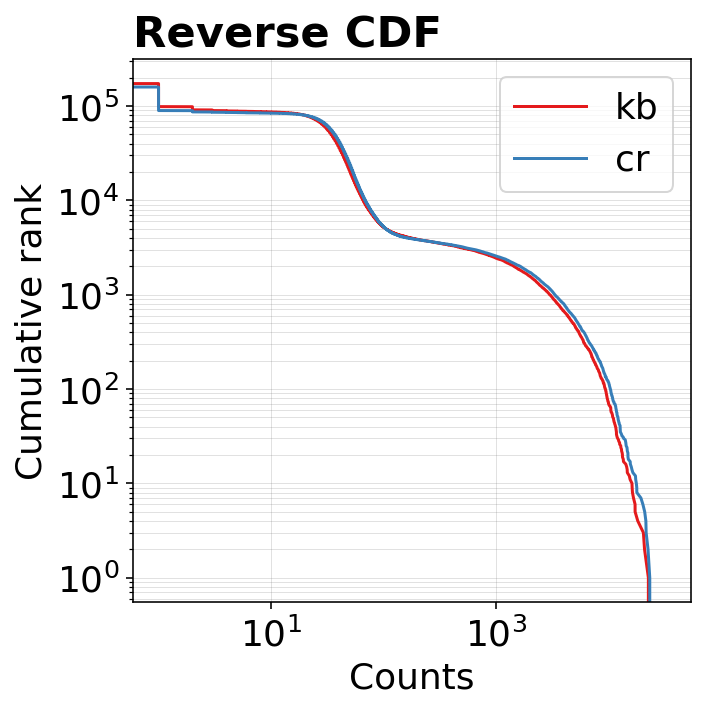

In [56]:
fig, ax = plt.subplots(figsize=(5,5))

x0,x1 = compare.rev_cdf(kb.X, cr.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors)

fig.show()

## pseudobulk

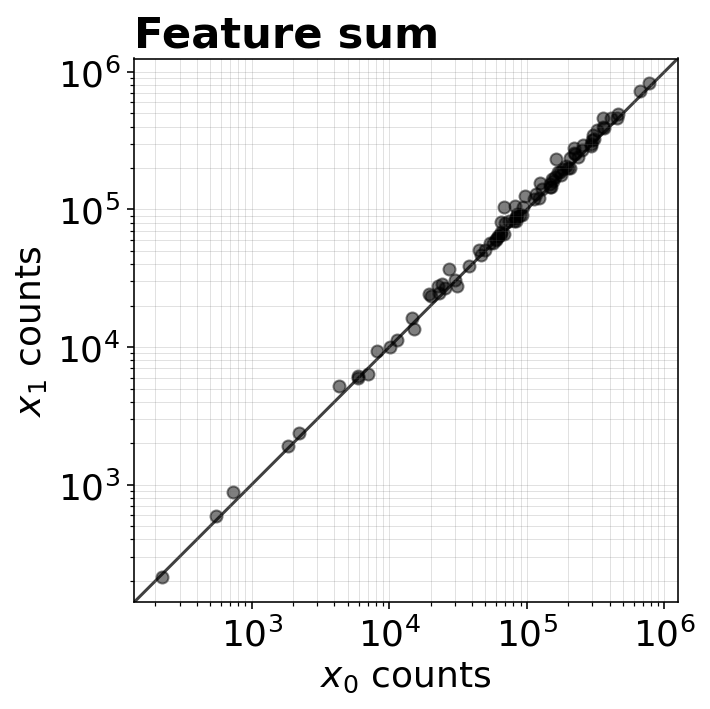

In [57]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cr.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

fig.show()

In [58]:
print(kb.var.iloc[np.argmax(np.abs(x1-x0).astype(int))])
print(cr.var.iloc[np.argmax(np.abs(x1-x0).astype(int))])

feature_name    PPIB-1
Name: PPIB-1, dtype: object
gene_name    PPIB-1
Name: PPIB-1, dtype: object


# Pseudobulk - cell

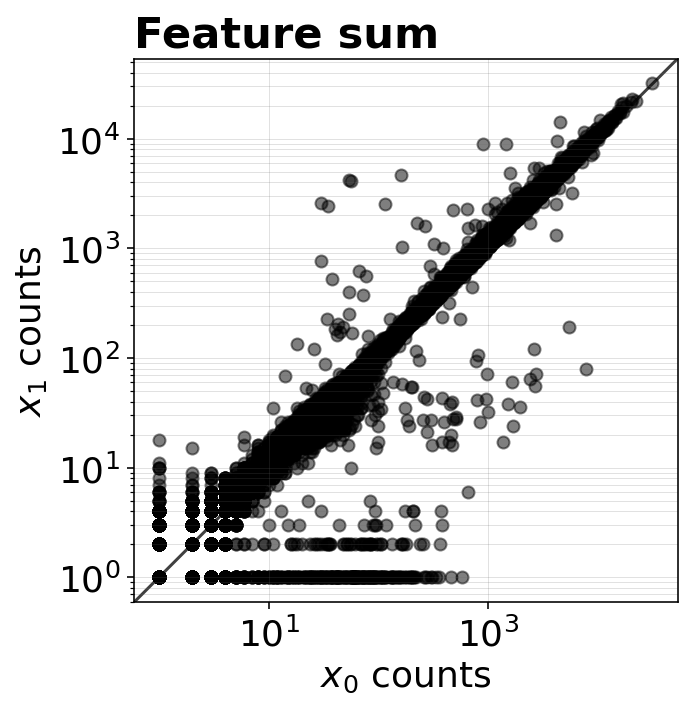

In [59]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cr.X, axis=1)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

fig.show()

In [60]:
print(kb.obs.iloc[np.argmax(np.abs(x1-x0).astype(int))])
print(cr.obs.iloc[np.argmax(np.abs(x1-x0).astype(int))])

Series([], Name: TACCCGTAGAACCCGA, dtype: float64)
Series([], Name: TACCCGTAGAACCCGA, dtype: float64)


In [61]:
kb.var["feat_counts"] = nd(kb.X.sum(axis=0)).astype(int)
cr.var["feat_counts"] = nd(cr.X.sum(axis=0)).astype(int)

In [62]:
(kb.var-cr.var).query("feat_counts<0")

,feat_counts,feature_name,gene_name
feature_id,,,
APH1A-1,-44362,NaN,NaN
APH1A-2,-3313,NaN,NaN
CDKN3-1,-13744,NaN,NaN
CDKN3-2,-43093,NaN,NaN
EZR-2,-33442,NaN,NaN
...,...,...,...
RAB1A-3,-5915,NaN,NaN
DPP4-1,-4706,NaN,NaN
DPP4-2,-1826,NaN,NaN


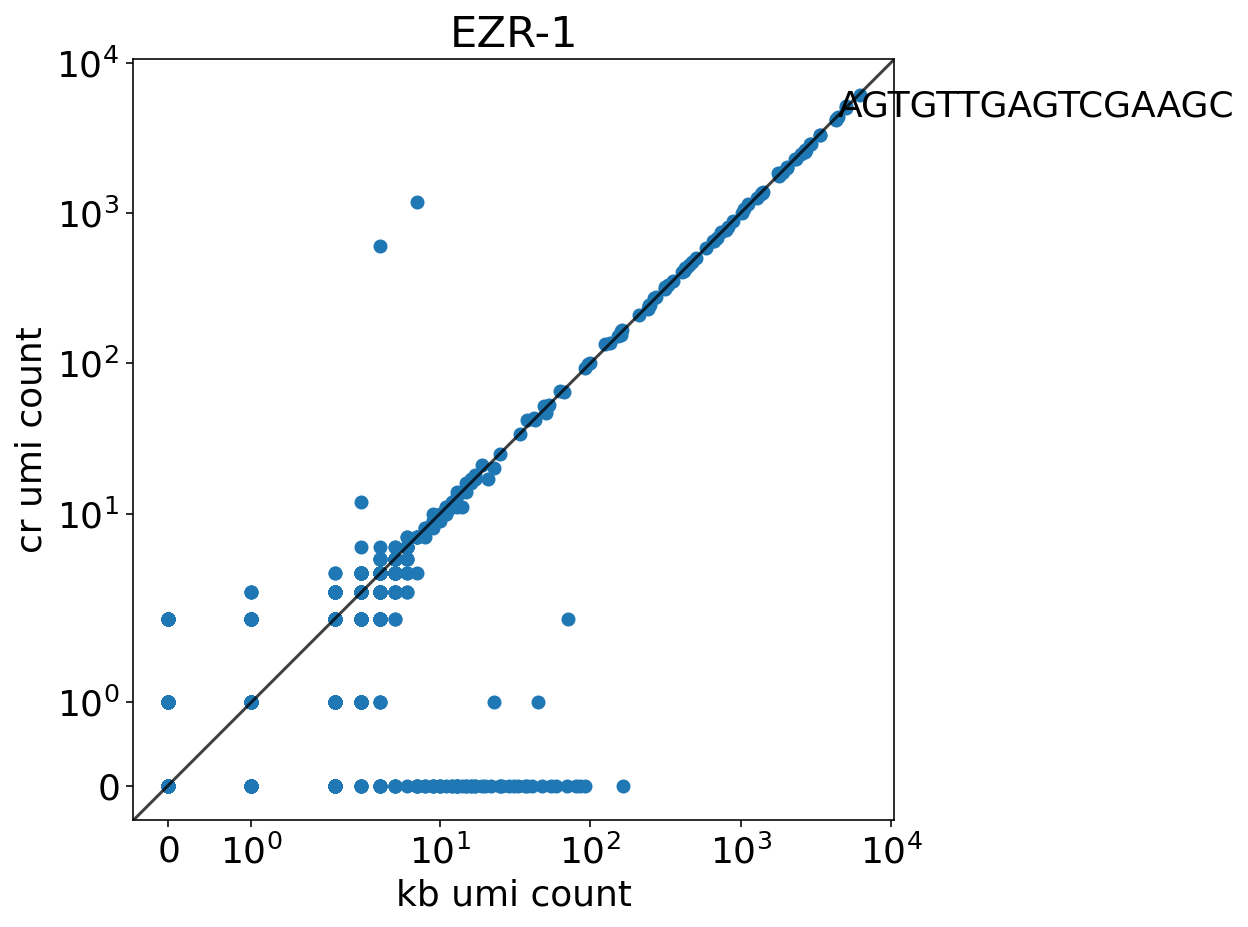

In [63]:
# look at just these two features
fig, ax = plt.subplots(figsize=(7,7))

feature = 'EZR-1'
x = nd(kb.X[:,kb.var.index.values == feature].todense())
y = nd(cr.X[:,cr.var.index.values == feature].todense())

ax.scatter(x,y)

ax.set(**{
    "xlabel": "kb umi count",
    "ylabel": "cr umi count",
    "xscale": "symlog",
    "yscale": "symlog",
    "title": feature

})
yex(ax)

for xx,yy,bc in zip(x,y, kb.obs.index.values):
  if bc == "AGTGTTGAGTCGAAGC":
    ax.text(xx,yy, bc)

fig.show()

In [64]:
print("kb : ", kb.X.todense()[:,kb.var.feature_name == "EZR-1"].sum())
print("cr : ", cr.X.todense()[:,cr.var.gene_name == "EZR-1"].sum())

kb :  122225.0
cr :  120172.0


In [65]:
print("kb : ", raw_kb.X[raw_kb.obs.index.values == "AGTGTTGAGTCGAAGC"].todense().sum())
print("cr : ", raw_cr.X[raw_cr.obs.index.values == "AGTGTTGAGTCGAAGC"].todense().sum())

kb :  6567.0
cr :  13326.0


In [66]:
GOI = "EZR-1"
COI = "AGTGTTGAGTCGAAGC"

gene_mask = raw_kb.var.feature_name.values == GOI
cell_mask = raw_kb.obs.index.values == COI

print("kb: ", raw_kb.X[cell_mask, gene_mask])

kb:  [[4420.]]


In [67]:
COI = "AGTGTTG TC TCGAAGC" # from fq\
COI = "AGTGTTG TC TCGAAGC" # from fq

In [68]:
len("AGCCCAAGCCAGAGCGGCGGTTT")

23

In [ ]:
AAGCAGTGGTATCAACGCAGAGTACAT GGGG AGCCCAAGCCAGAGCGGCG GTTT AAGAGCTAAGCTGGAAACAGCATAGCAAGTTTAAAT
                            GGGG AGCCCAAGCCAGAGCGGCG GTTT
                                 AGCCCAAGCCAGAGCGGCG

In [70]:
GOI = "EZR-1"
COI = "AGTGTTGTCTCGAAGC"

gene_mask = raw_kb.var.feature_name.values == GOI
cell_mask = raw_kb.obs.index.values == COI

print("kb: ", raw_kb.X[cell_mask, gene_mask])

kb:  [[164.]]


In [71]:
GOI = "EZR-1"
COI = "AGTGTTGAGTCGAAGC"

gene_mask = raw_cr.var.gene_name.values == GOI
cell_mask = raw_cr.obs.index.values == COI

print("cr: ", raw_cr.X[cell_mask, gene_mask])

cr:  [[4376.]]


In [ ]:
nd(raw_cr.X[raw_cr.obs.index.values == COI].todense())[cr.var.gene_name == "EZR-1"]

In [28]:
amax = np.argmax(y-x)

In [29]:
print(kb.obs.index.values[amax])
print(cr.obs.index.values[amax])

GATCGTATCAGTCCGG
GATCGTATCAGTCCGG


In [30]:
y[amax], x[amax]

(6075.0, 678.0)

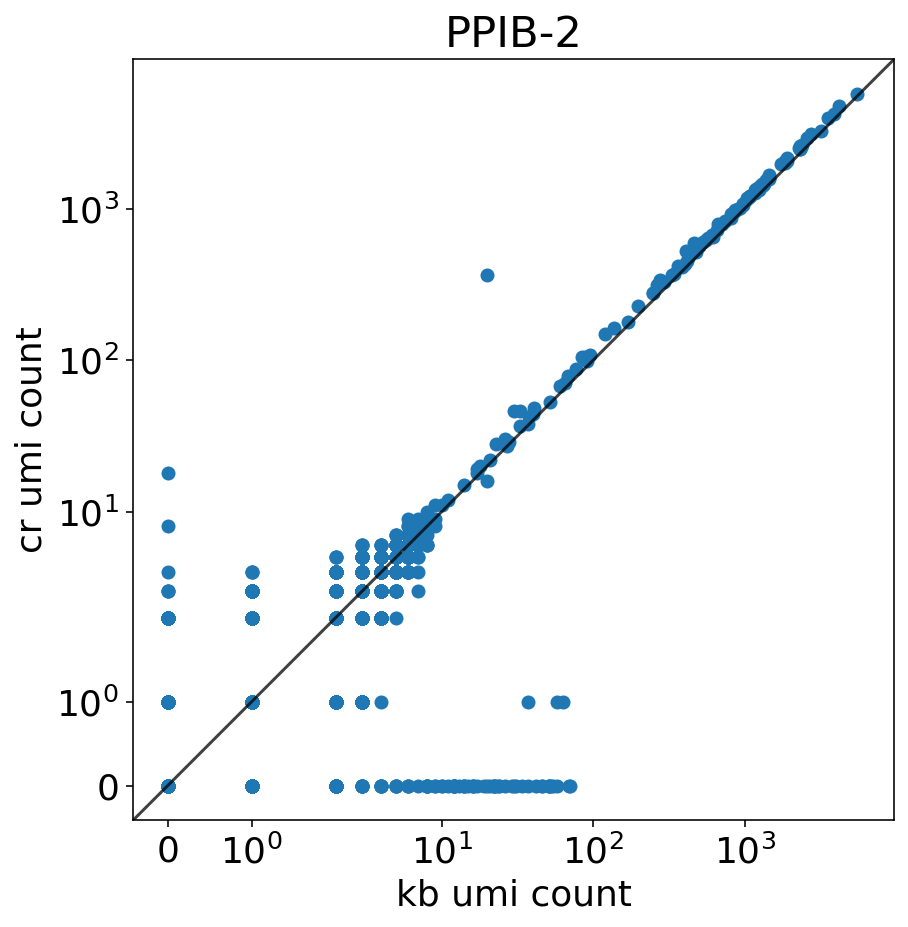

In [72]:
# look at just these two features
fig, ax = plt.subplots(figsize=(7,7))

feature = 'PPIB-2'
x = nd(kb.X[:,kb.var.index.values == feature].todense())
y = nd(cr.X[:,cr.var.index.values == feature].todense())

ax.scatter(x,y)

ax.set(**{
    "xlabel": "kb umi count",
    "ylabel": "cr umi count",
    "xscale": "symlog",
    "yscale": "symlog",
    "title": feature

})
yex(ax)

fig.show()

In [36]:
features = pd.read_csv("BMGP_2020/references/10xCRISPR/kite/feature_barcodes.txt", header = None, names=["bcs", "name"], sep="\t")

In [39]:
features.query("name == 'EZR-1' or name == 'PPIB-2'")

,bcs,name
7,CACTCGGCGGACGCAAGGG,EZR-1
18,GAGGCGCAGCATCCACAGG,PPIB-2


In [24]:
gene_mask

feature_id
Non-Targeting-5     True
Non-Targeting-7     True
Non-Targeting-8     True
APH1A-1            False
APH1A-2            False
                   ...  
RAB1A-3            False
DPP4-1             False
DPP4-2             False
HDAC1-1            False
HDAC1-2            False
Name: feature_name, Length: 93, dtype: bool

In [26]:
gene_mask = raw_kb.var.feature_name.str.contains("Non-Target").values
raw_kb.X[:,gene_mask].sum(0)

matrix([[520021., 573464., 670735.]], dtype=float32)

In [28]:
gene_mask = raw_cr.var.gene_name.str.contains("Non-Target").values
raw_cr.X[:,gene_mask].sum(0)

matrix([[477324., 467454., 619127.]], dtype=float32)

In [31]:
gene_mask = raw_kb.var.feature_name.str.contains("Non-Target").values
raw_kb.obs.iloc[np.argmax(nd(raw_kb.X[:,gene_mask].sum(1)))]

Series([], Name: AAGCCATGTGACTATC, dtype: float64)

In [36]:
raw_kb.X[raw_kb.obs.index.values == "AAGCCATGTGACTATC", ~gene_mask].astype(int)

matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 0,
         0, 0, 0, 0, 0, 0]])

# Feature correlation

/home/sina/bin/miniconda3/lib/python3.7/site-packages/diffmx/compare.py:62: RuntimeWarning: invalid value encountered in true_divide
  R = np.divide(XY_cov, XY_std)


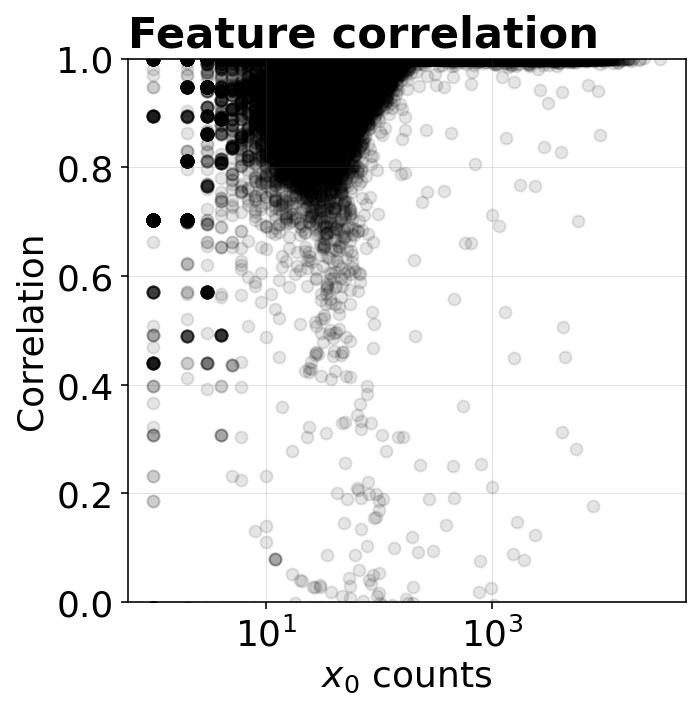

In [73]:
fig, ax = plt.subplots(figsize=(5,5))

x0, corr = compare.features_correlated(kb.X, cr.X)
plot.features_correlated(x0, corr, ax=ax)

fig.show()

### $l_1$ dist

In [74]:
# logged counts
XX_XY = compare.l1_distance(np.log1p(kb.X), np.log1p(cr.X))
YY_YX = compare.l1_distance(np.log1p(cr.X), np.log1p(kb.X))

MemoryError: Unable to allocate 225. GiB for an array with shape (173586, 173586) and data type float64

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                         ax=ax, 
                         labels=labels, 
                         colors=colors)

fig.show()

In [54]:
XX, XY = XX_XY
YY, YX = YY_YX

In [55]:
# logged counts
cnts = compare.sum_features(np.log1p(kb.X), axis=1)

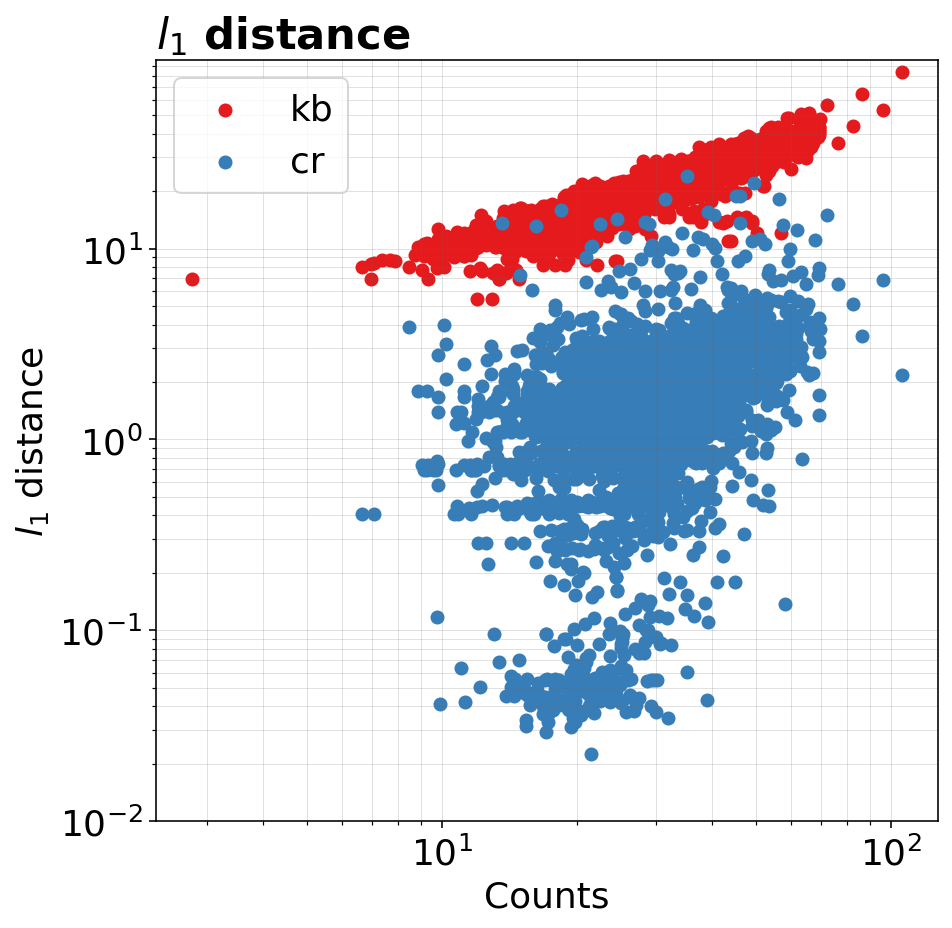

In [59]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_counts((cnts, XX), (cnts, XY), 
               ax=ax, 
               colors=colors,
               labels=labels)
ax.set(**{"ylim": 0.01})

fig.show()